#  Setup

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from foraging import plotting
from foraging import utils
from matplotlib.lines import Line2D

import plotting.beliefs
import utils.beliefs
import utils.data
from plotting import BOX_LABELS, BOX_COLORS
from plotting import bp

# constants
SEED = 42
RNG = np.random.default_rng(SEED)
DATA_DIR = '../data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

The experiment data consists of multiple matfiles corresponding to the data for different subjects. Each matfile contains that subject's push, eye tracking (if available), and position (if available) data organized by blocks and sessions. Each block corresponds to a set of experiment parameters, notably the schedule of each box, the stimulus reliability kappa, and the stimulus type. A hierarchical overview of a given matfile is given in the `Angelaki Data Cleaning` notebook.

In [3]:
'''
-session
-- block [array] (each item is a session)
---- events [array] (each item is a block)
------ tStartBeh, tEndBeh = start and end time of trial
--------- tPush, tReward, pushLogical = arrays of push times, rewarded push times, and boolean for rewarded pushes
----------- all, box1, box2, box3, id
---- params [array]
------ boxIdx, kappa, rewardRateFraction, rewardRates, rewardWaitTime, schedules
'''

df = utils.data.make_dataframe(os.path.join(DATA_DIR, 'experiments'))
df = utils.data.exclusion_criteria(df)
df = utils.data.filter_df(df, {'kappa': 0})
df.index.unique(), len(df)

(MultiIndex([('humans',  1, 3,   1, 'availability', 10, 0.0, nan),
             ('humans',  1, 3,   2, 'availability', 10, 0.0, nan),
             ('humans',  1, 3,   3, 'availability', 10, 0.0, nan),
             ('humans',  1, 3,   4, 'availability', 10, 0.0, nan),
             ('humans',  1, 3,   5, 'availability', 10, 0.0, nan),
             ('humans',  1, 3,   6, 'availability', 10, 0.0, nan),
             ('humans',  1, 3,   7, 'availability', 10, 0.0, nan),
             ('humans',  1, 3,   8, 'availability', 10, 0.0, nan),
             ('humans',  1, 3,   9, 'availability', 10, 0.0, nan),
             ('humans',  1, 3,  10, 'availability', 10, 0.0, nan),
             ...
             ('viktor', 41, 3, 166, 'availability', 10, 0.0, 'R'),
             ('viktor', 41, 3, 167, 'availability', 10, 0.0, 'R'),
             ('viktor', 41, 3, 168, 'availability', 10, 0.0, 'R'),
             ('viktor', 41, 3, 169, 'availability', 10, 0.0, 'R'),
             ('viktor', 41, 3, 170, 'availabi

Now load pre-existing data structures generated in `Bulk Data Processing`.

In [4]:
ds = utils.data.load_pickled_data(os.path.join(DATA_DIR, 'analysis/bulk_beliefs.pkl'))
data, error, schedule_candidates, dt, pt = ds.values()
posteriors, latent_beliefs_over_time, joint_beliefs, reward_beliefs, reward_probabilities = list(data.values())
error_all = set().union(*error.values())

# Align dataframe and belief data by dropping problematic blocks
if len(error_all) > 0:
    df = df.drop(error_all)

 # Schedule beliefs

Get the mean and standard deviation of the posteriors of the mean schedules for each block.

In [8]:
def mean(df: pd.DataFrame, index: tuple, exclude_prior: bool = True):
    res = utils.beliefs.get_mean_beliefs(posteriors[index].probabilities(record='all'), posteriors[index].support())
    if exclude_prior:
        return [x[1:] for x in res]
    return res


def std(df: pd.DataFrame, index: tuple, exclude_prior: bool = True):
    res = utils.beliefs.get_std_beliefs(posteriors[index].probabilities(record='all'), posteriors[index].support())
    if exclude_prior:
        return [x[1:] for x in res]
    return res

mean_schedule, err_mean = utils.data.process_blocks(df, mean)
uncertainty_schedule, err_uncertainty = utils.data.process_blocks(df, std)
utils.data.extend_df(df, mean_schedule, 'mean schedule')
utils.data.extend_df(df, uncertainty_schedule, 'uncertainty schedule');

Here are the beliefs from an example block. Feel free to change the `index` values to change the block to display. You can also change `x_col` parameter to `push times` or even `push # by box` which shows the beliefs as a function of experience at each box.

<Axes: title={'center': "Beliefs about schedule for ('viktor', 29, 3)\nkappa = 0.0, stim type = availability, shape = 10"}, xlabel='push #', ylabel='mean schedule'>

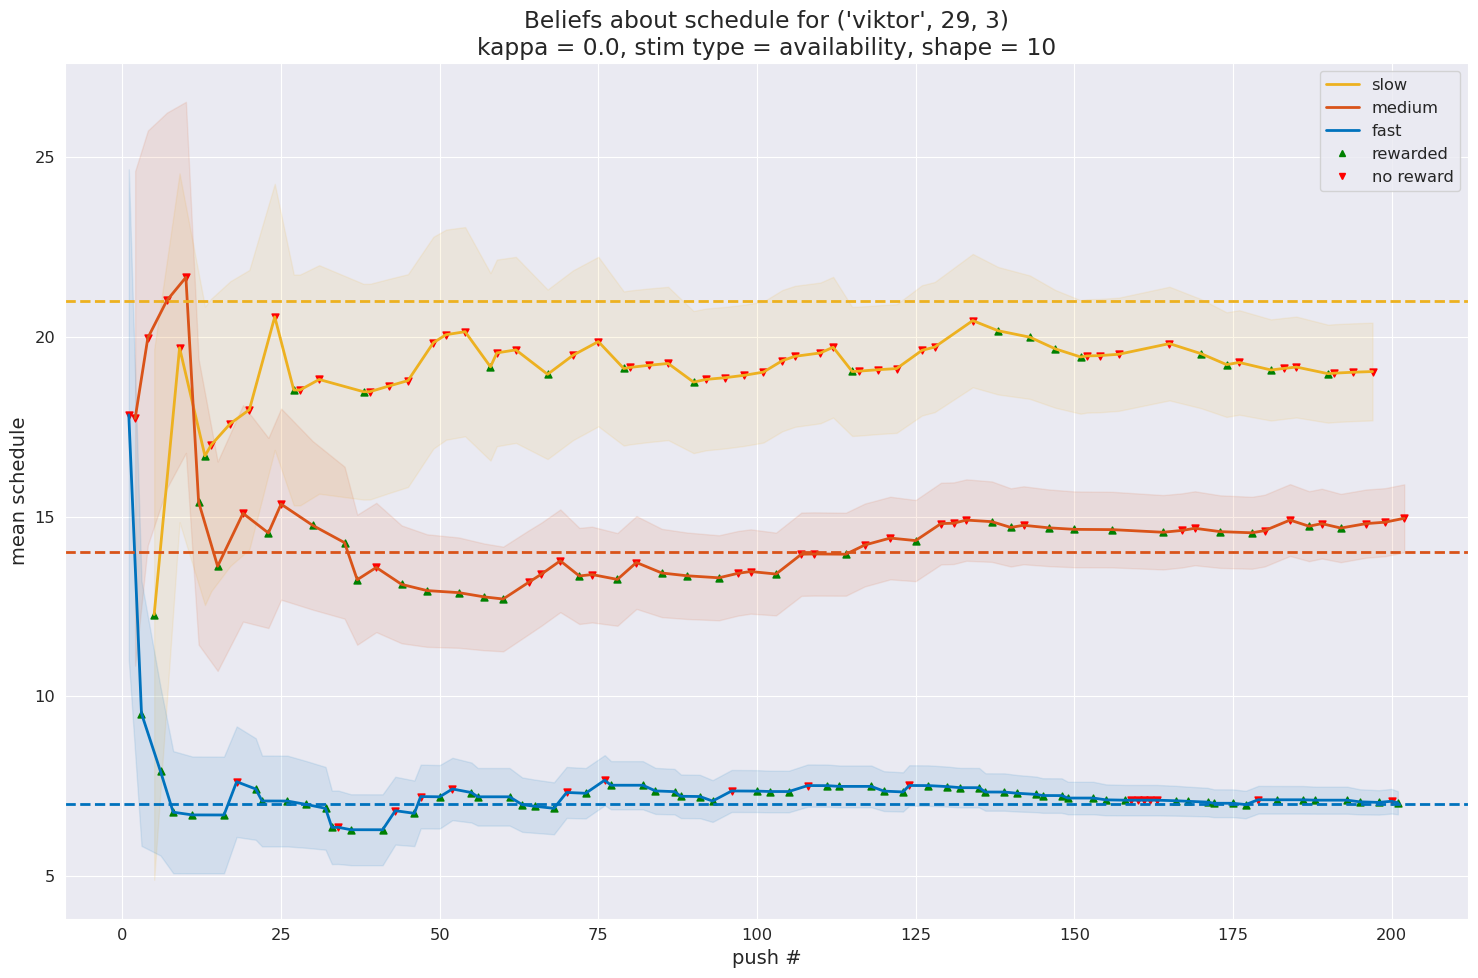

In [11]:
index = 'viktor', 29, 3
plotting.beliefs.schedule_beliefs_block(df, index)

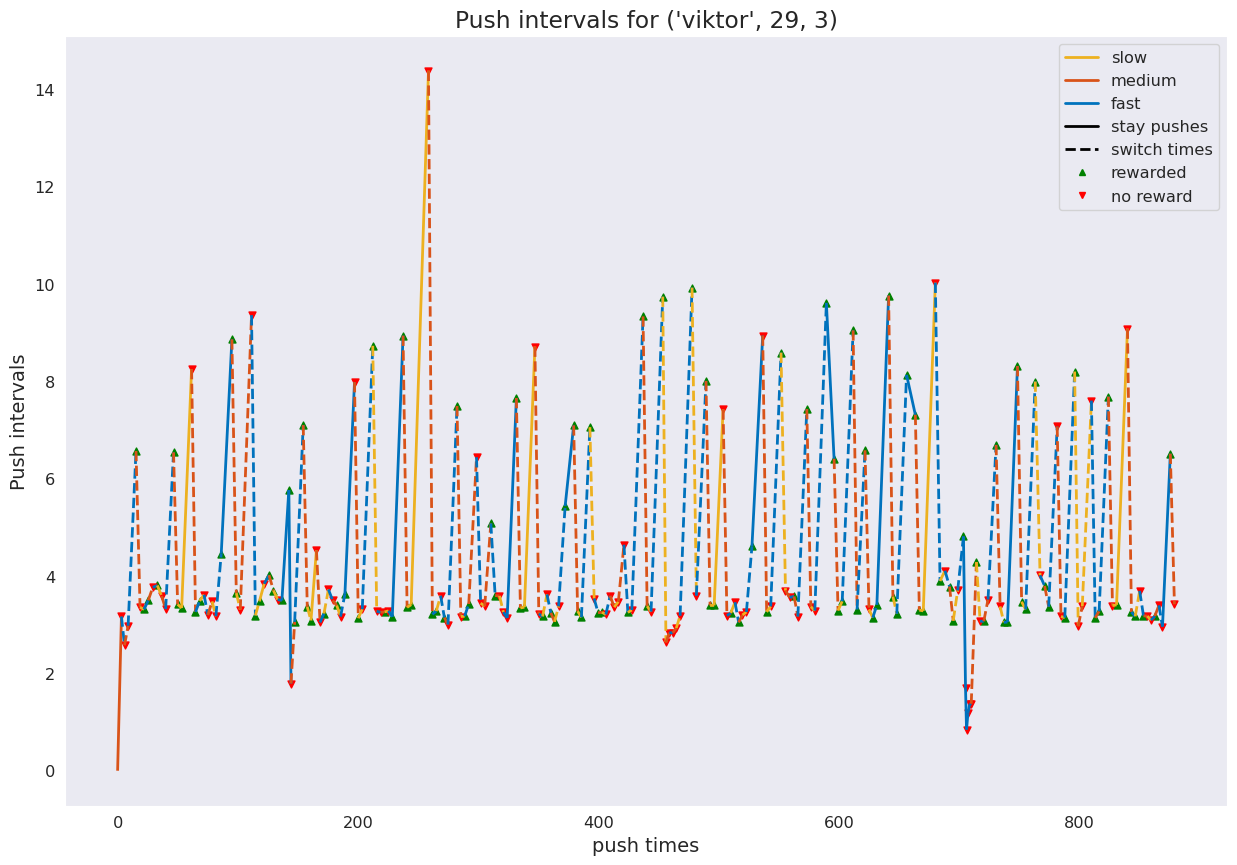

In [8]:
plotting.behavior.plot_push_intervals(df.loc[index], title=f'Push intervals for {index}')

<Axes: title={'center': 'Uncertainty as function of experience in block\nsubject = viktor'}, xlabel='push #', ylabel='uncertainty schedule'>

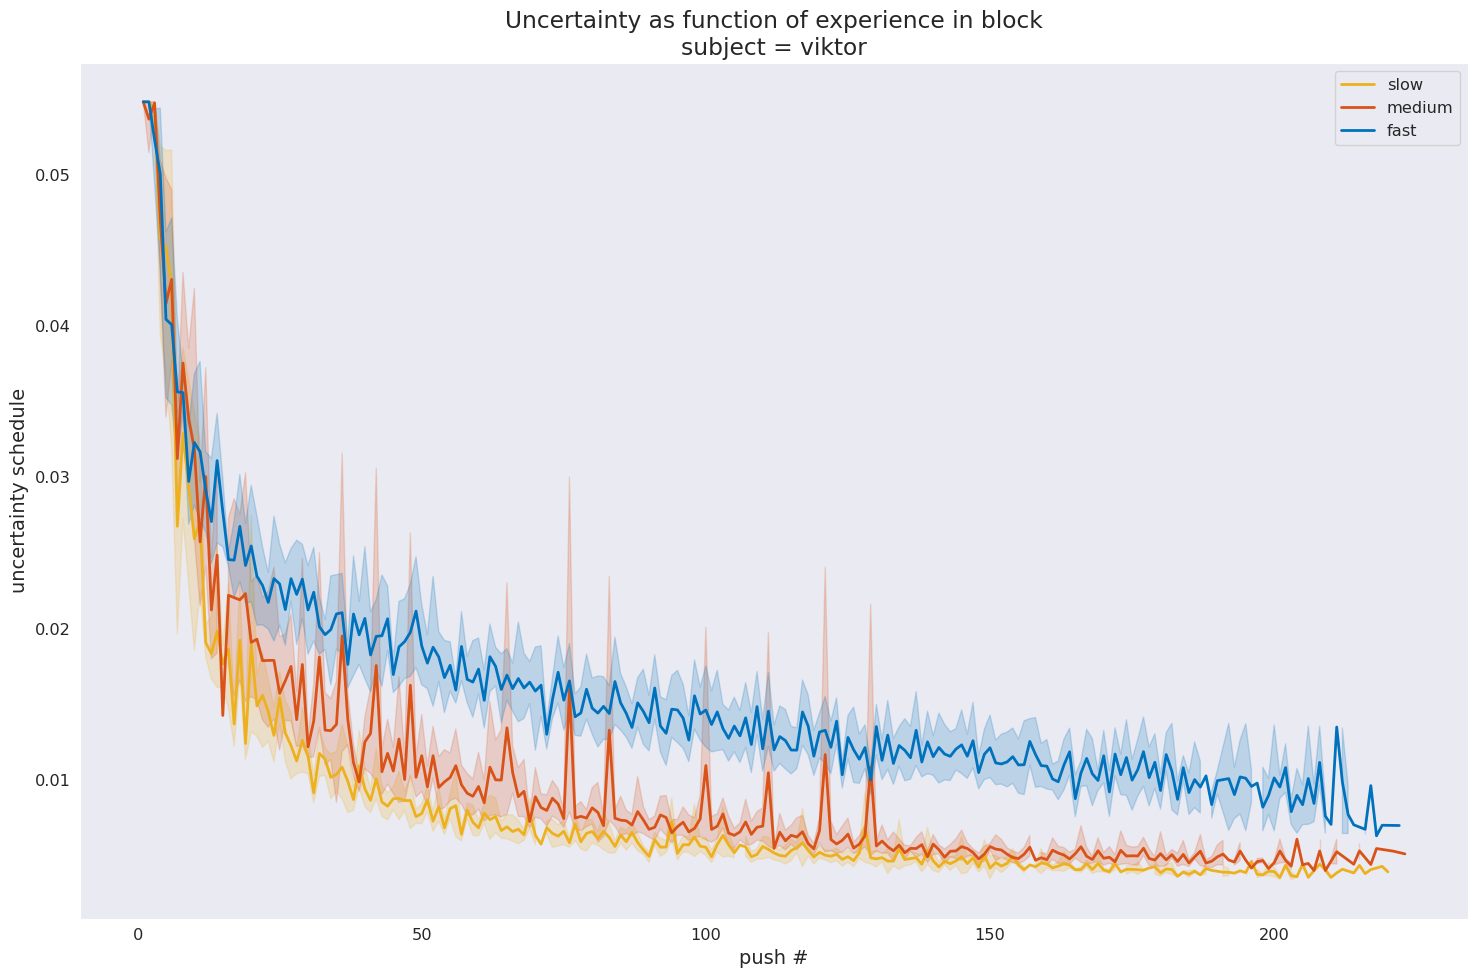

In [9]:
conds = {'subject': 'viktor'}
df_monkey = utils.data.filter_df(df, conds=conds)
bp(sns.lineplot)(df_monkey, conds=conds, x='push #', y='uncertainty schedule', collapse=True,
                 title_prefix="Uncertainty as function of experience in block")

<Axes: title={'center': 'Uncertainty as function of experience in block\nsubject = viktor'}, xlabel='push #_binned', ylabel='reward outcomes'>

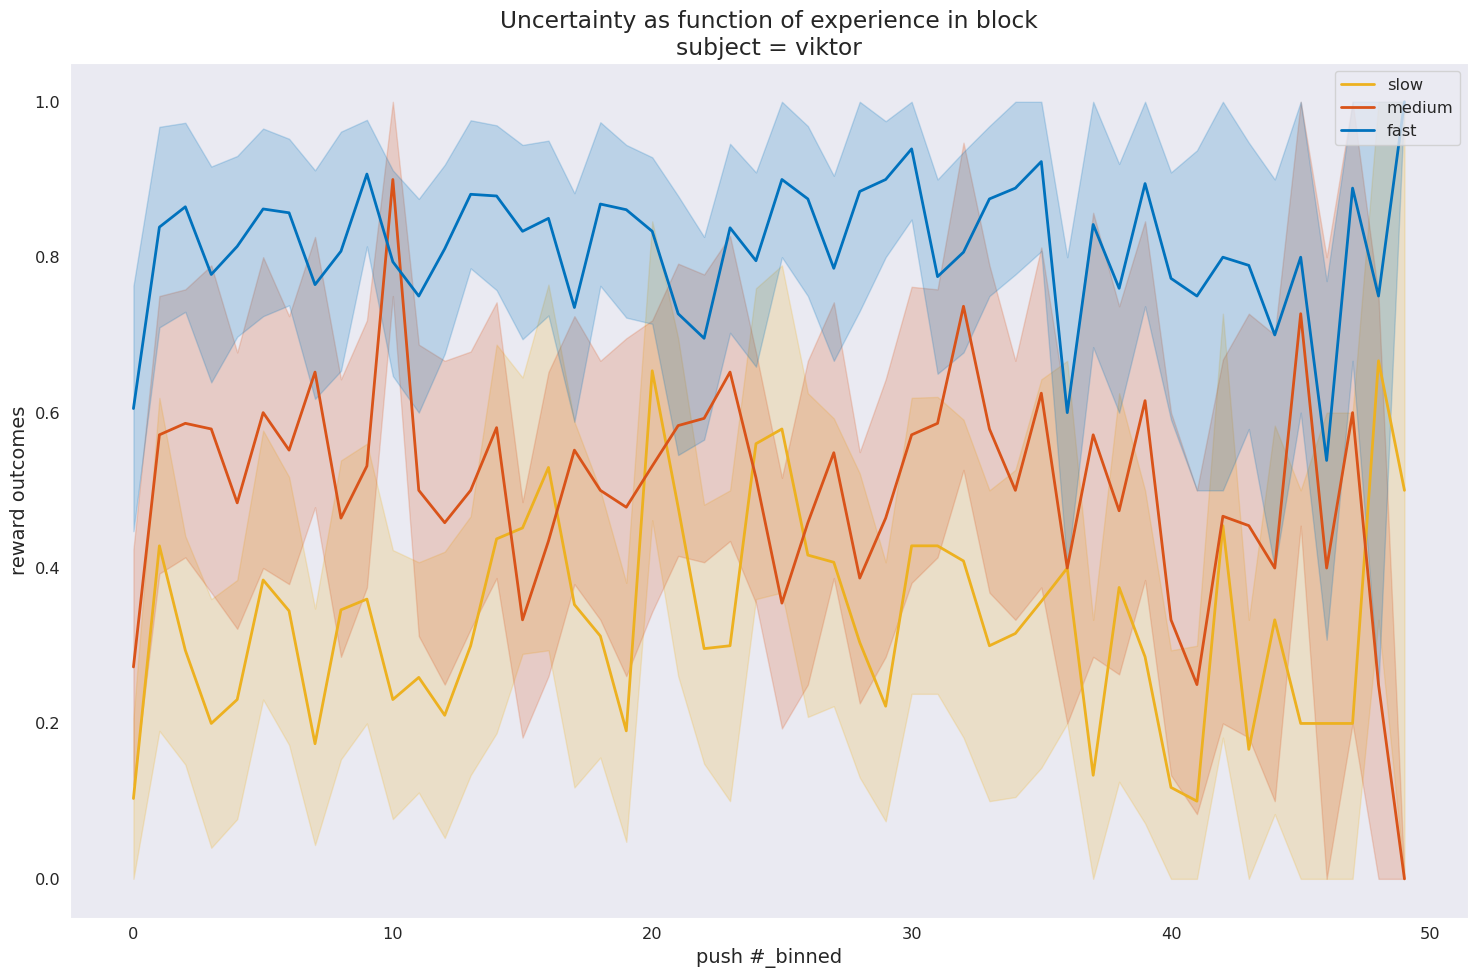

In [10]:
conds = {'subject': 'viktor'}
df_monkey = utils.data.filter_df(df, conds=conds).reset_index()
num_bins = 50
df_monkey["push #_binned"] = pd.cut(df_monkey["push #"], bins=num_bins, labels=False)  # Assign bin indices
bp(sns.lineplot)(df_monkey, conds=conds, x='push #_binned', y='reward outcomes', collapse=True,
                 title_prefix="Uncertainty as function of experience in block")

## Likelihood

Text(0.5, 0.92, 'Likelihood after observing reward')

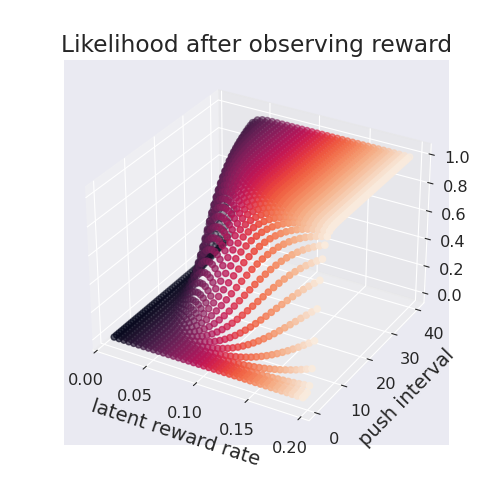

In [19]:
%matplotlib ipympl
pts = np.linspace(0.2, 40)
LL = np.zeros((len(supp) * len(pts), 3))
shape = 10
obs_model = utils.models.GammaObservation(shape)
c = np.zeros(LL.shape[0])
cnt = 0
for i, latent in enumerate(supp):
    for j, pt in enumerate(pts):
        LL[cnt] = (latent, pt, obs_model.probability((1, pt), latent))
        c[cnt] = latent
        cnt += 1
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(LL[:, 0], LL[:, 1], LL[:, 2], c=c)
ax.set_xlabel("latent reward rate")
ax.set_ylabel("push interval")
ax.set_title("Likelihood after observing reward")
# df_monkey['same-box push intervals'].min(), df_monkey['schedule'].max()

# Schedule beliefs

In [51]:
subject, sess_num, block_num = 'viktor', 1, 1
schedule_belief_event = schedule_belief_bulk[]
schedule_belief_time = utils.beliefs.compute_latent_beliefs_over_time(df, subject, sess_num, block_num, supp,
                                                                      schedule_belief_event, dt=0.5, padding_time=0.5)

array([ 1.65964702,  0.19092534, -0.72637016])

<Axes3D: title={'center': 'Belief about reward availability \nat time of push for viktor'}, xlabel='belief that reward is available at slow box', ylabel='belief that reward is available at medium box', zlabel='belief that reward is available at fast box'>

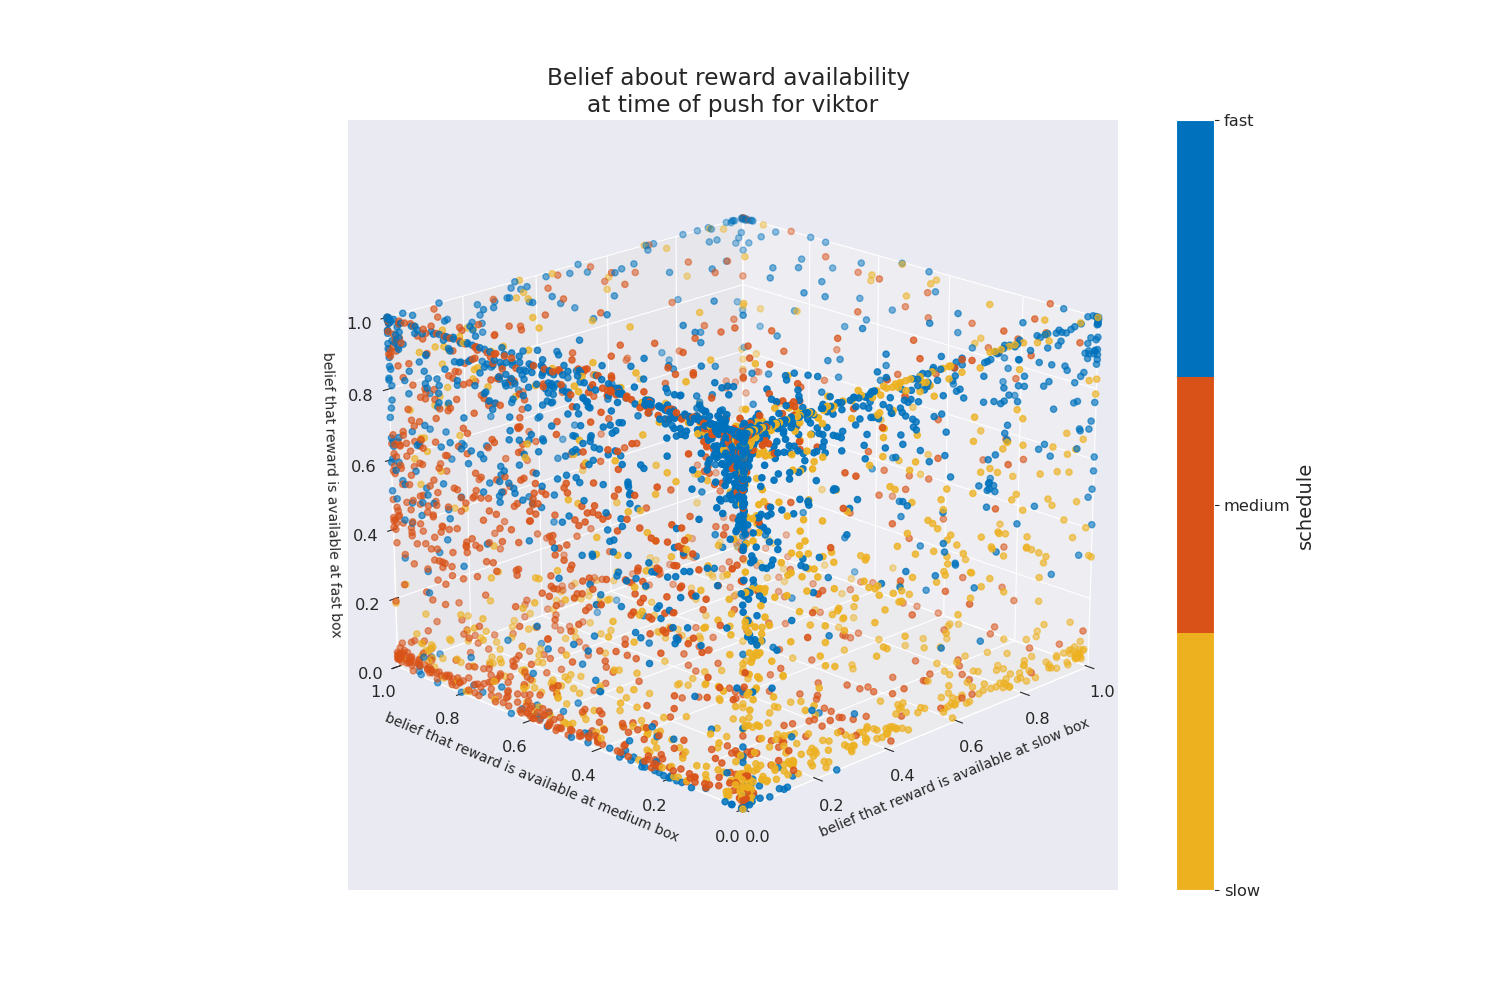

In [26]:
subject = 'viktor'
df_subj = utils.data.filter_df(df, {'subject': subject})
beliefs = []
for k, v in reward_belief_bulk.items():
    if k[0] == subject:
        beliefs.append(v)
beliefs = np.vstack(beliefs)
plotting.beliefs.reward_beliefs3d(df_subj, beliefs,
                                  title=f"Belief about reward availability \nat time of push for {subject}")

<Axes3D: title={'center': 'Exact reward probability \nat time of push for viktor'}, xlabel='belief that reward is available at slow box', ylabel='belief that reward is available at medium box', zlabel='belief that reward is available at fast box'>

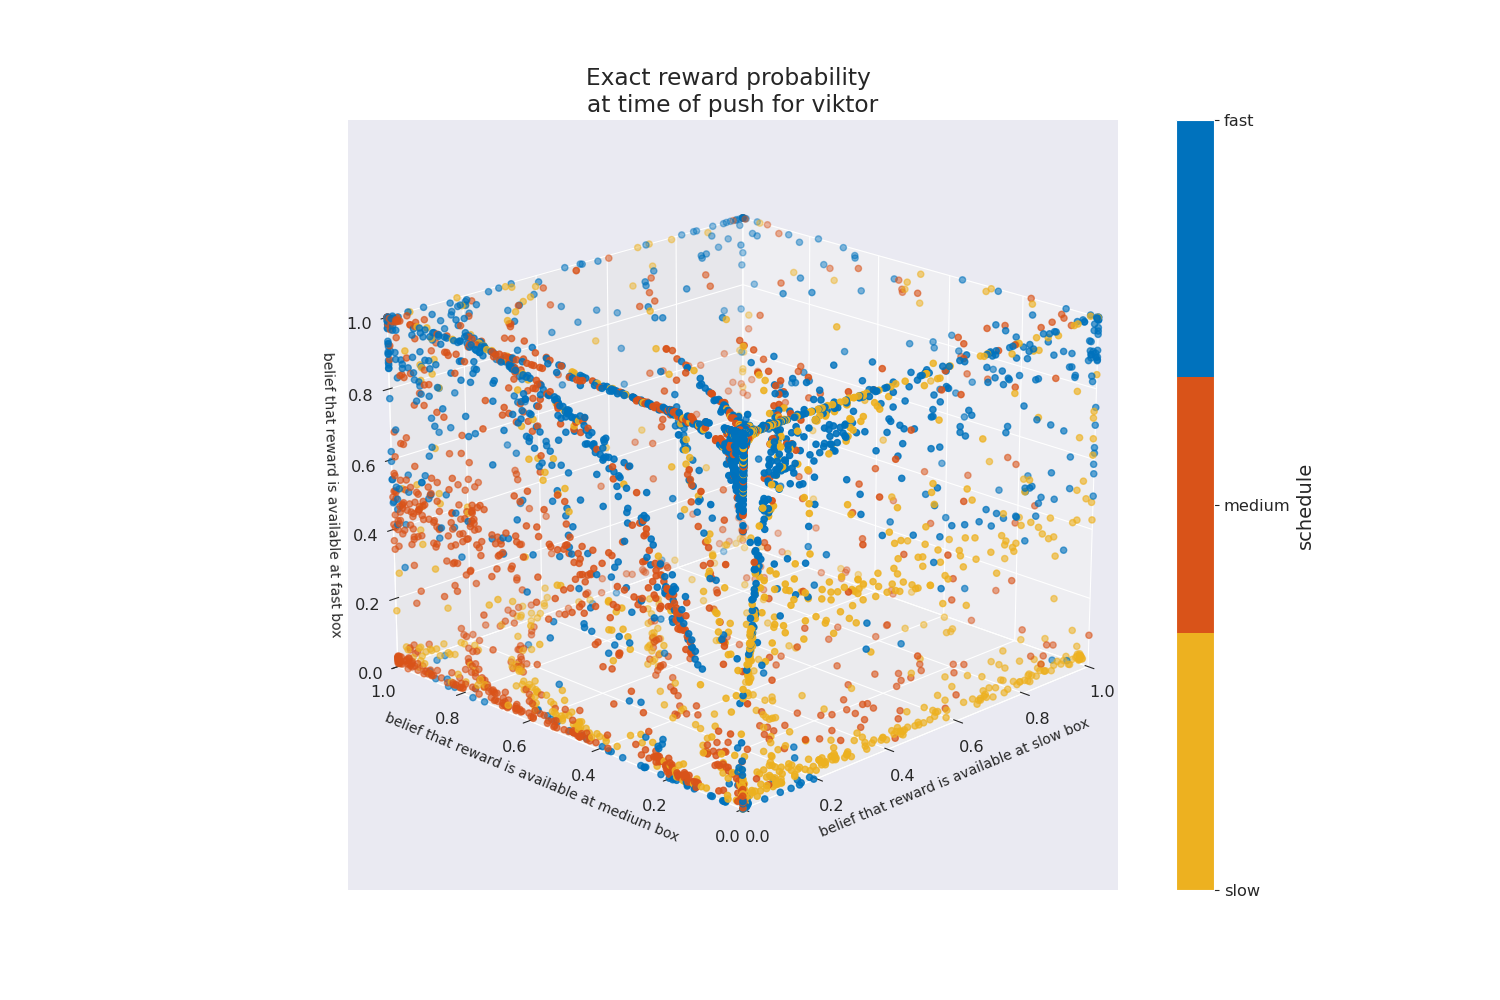

In [30]:
rew_probs = []
for k, v in reward_probability_bulk.items():
    if k[0] == subject:
        rew_probs.append(v)
rew_probs = np.vstack(rew_probs)
plotting.beliefs.reward_beliefs3d(df_subj, rew_probs, title=f"Exact reward probability \nat time of push for {subject}")

In [31]:
# marginal beliefs
marginal_score, marginal_mdl = utils.beliefs.predict_pushed_box(df_subj, beliefs)

# perfect beliefs
perfect_score, perfect_mdl = utils.beliefs.predict_pushed_box(df_subj, rew_probs)
print(f"marginal belief score: {marginal_score}\nperfect belief score: {perfect_score}")
marginal_mdl.summary(), perfect_mdl.summary()

Optimization terminated successfully.
         Current function value: 0.884790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.886398
         Iterations 6
marginal belief score: 0.6035812672176308
perfect belief score: 0.6060606060606061


(<class 'statsmodels.iolib.summary.Summary'>
 """
                           MNLogit Regression Results                          
 Dep. Variable:                      y   No. Observations:                 3630
 Model:                        MNLogit   Df Residuals:                     3622
 Method:                           MLE   Df Model:                            6
 Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                  0.1837
 Time:                        14:17:18   Log-Likelihood:                -3211.8
 converged:                       True   LL-Null:                       -3934.8
 Covariance Type:            nonrobust   LLR p-value:                2.696e-309
        y=1       coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 Intercept     -0.6698      0.101     -6.624      0.000      -0.868      -0.472
 X[0]          -1.5102      0.151    -10.018      0.000      -1.806   

In [76]:
# todo: due to filtering pushes, push # may get misaligned. consider saving push # info when generating beliefs
# monkey patch for now
subject = 'viktor'
df_subj = utils.data.filter_df(df, {'subject': subject}).copy(deep=True)
df_subj['push #_fixed'] = df_subj.groupby(['subject', 'session', 'block'])['push times'].rank().astype(int)

# split into different segments of times and do analysis
df_early = df_subj[df_subj['push #_fixed'] <= 75]
df_late = df_subj[df_subj['push #_fixed'] > 75]

early_blocks = utils.data.get_blocks(df_early)
late_blocks = utils.data.get_blocks(df_late)
early_beliefs = []
late_beliefs = []
early_rew_probs = []
late_rew_probs = []
for key, block in early_blocks:
    if key in reward_belief_bulk:
        early_beliefs.append(reward_belief_bulk[key][block['push #_fixed'].values - 1])
        early_rew_probs.append(reward_probability_bulk[key][block['push #_fixed'].values - 1])

for key, block in late_blocks:
    if key in reward_belief_bulk:
        late_beliefs.append(reward_belief_bulk[key][block['push #_fixed'].values - 1])
        late_rew_probs.append(reward_probability_bulk[key][block['push #_fixed'].values - 1])

early_beliefs = np.vstack(early_beliefs)
late_beliefs = np.vstack(late_beliefs)
early_rew_probs = np.vstack(early_rew_probs)
late_rew_probs = np.vstack(late_rew_probs)

# marginal beliefs
marginal_score, marginal_mdl = utils.beliefs.predict_pushed_box(df_early, early_beliefs)

# perfect beliefs
perfect_score, perfect_mdl = utils.beliefs.predict_pushed_box(df_early, early_rew_probs)
print(f"marginal belief score: {marginal_score}\nperfect belief score: {perfect_score}")
marginal_mdl.summary(), perfect_mdl.summary()

Optimization terminated successfully.
         Current function value: 0.898377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.896415
         Iterations 6
marginal belief score: 0.5886666666666667
perfect belief score: 0.6


(<class 'statsmodels.iolib.summary.Summary'>
 """
                           MNLogit Regression Results                          
 Dep. Variable:                      y   No. Observations:                 1500
 Model:                        MNLogit   Df Residuals:                     1492
 Method:                           MLE   Df Model:                            6
 Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                  0.1729
 Time:                        15:09:34   Log-Likelihood:                -1347.6
 converged:                       True   LL-Null:                       -1629.2
 Covariance Type:            nonrobust   LLR p-value:                1.857e-118
        y=1       coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 Intercept     -0.7265      0.154     -4.728      0.000      -1.028      -0.425
 X[0]          -1.2376      0.228     -5.434      0.000      -1.684   

In [77]:
marginal_score, marginal_mdl = utils.beliefs.predict_pushed_box(df_late, late_beliefs)

# perfect beliefs
perfect_score, perfect_mdl = utils.beliefs.predict_pushed_box(df_late, late_rew_probs)
print(f"marginal belief score: {marginal_score}\nperfect belief score: {perfect_score}")
marginal_mdl.summary(), perfect_mdl.summary()

Optimization terminated successfully.
         Current function value: 0.873862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.878214
         Iterations 6
marginal belief score: 0.6140845070422535
perfect belief score: 0.6089201877934273


(<class 'statsmodels.iolib.summary.Summary'>
 """
                           MNLogit Regression Results                          
 Dep. Variable:                      y   No. Observations:                 2130
 Model:                        MNLogit   Df Residuals:                     2122
 Method:                           MLE   Df Model:                            6
 Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                  0.1925
 Time:                        15:09:39   Log-Likelihood:                -1861.3
 converged:                       True   LL-Null:                       -2305.2
 Covariance Type:            nonrobust   LLR p-value:                1.694e-188
        y=1       coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 Intercept     -0.6294      0.135     -4.679      0.000      -0.893      -0.366
 X[0]          -1.7201      0.202     -8.519      0.000      -2.116   